https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE128565
## Requirements and Imports

In [1]:
import copy
import os
from pathlib import Path
from itertools import combinations
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from numba import jit
from sklearn.metrics import roc_auc_score , pairwise_distances
import torch
import torch
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from pygsp import graphs, filters, plotting
from Annotatability import models, metrics
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [2]:
plt.rcParams.update({'font.size': 18,
                     'xtick.labelsize' : 18,
                     'ytick.labelsize' : 18})


In [3]:
# Read raw data and process it
adata = sc.read('GSE128565_adata_processed.h5ad.h5')
adata

AnnData object with n_obs × n_vars = 32888 × 18210
    obs: 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'groups', 'treatment', 'groups_named_broad', 'S_score', 'G2M_score', 'phase', 'proliferation', 'proliferation_man', 'doublet_score', 'groups_named_fine', 'groups_named_beta_dpt', 'Ins-Gcg-Sst', 'groups_named_broad_cond'
    var: 'n_cells', 'highly_variable_genes'
    uns: 'groups_named_beta_dpt_colors', 'groups_named_broad_colors', 'groups_named_fine_colors', 'proliferation_colors', 'proliferation_man_colors', 'rank_genes_groups', 'treatment_colors', 'treatment_colors_rgb'
    obsm: 'X_umap'

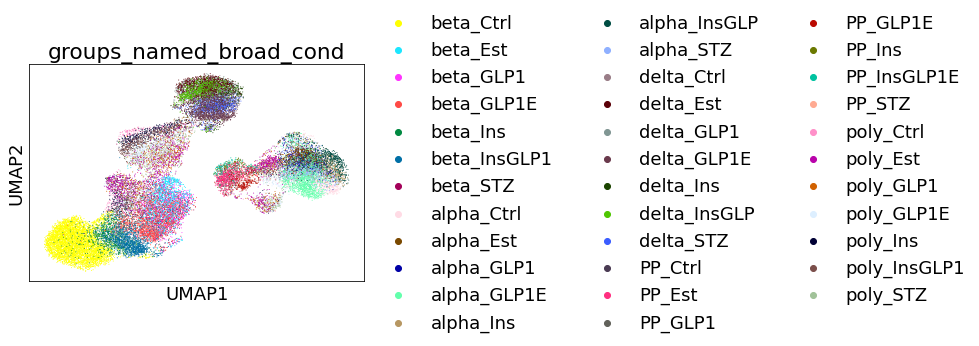

In [4]:
sc.pl.umap(adata,color='groups_named_broad_cond')

In [5]:
adata_stz = adata[adata.obs['groups_named_broad_cond'].isin(['beta_STZ','beta_GLP1','beta_Ins','beta_InsGLP1','beta_Est','beta_GLP1E',
                                                             'alpha_STZ','alpha_GLP1','alpha_Ins','alpha_InsGLP','alpha_Est','alpha_GLP1E',
                                                             'delta_STZ','delta_GLP1','delta_Ins','delta_InsGLP','delta_Est','delta_GLP1E',])]
adata_stz.obs['cond']='stz'
adata_ctrl = adata[adata.obs['groups_named_broad_cond'].isin(['beta_Ctrl','alpha_Ctrl'
                                                                  ,'delta_Ctrl'])]
adata_ctrl.obs['cond']='ctrl'
adata_stz_ctrl = adata_stz.concatenate(adata_ctrl)


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_48285/827724168.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_stz.obs['cond']='stz'
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_48285/827724168.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ctrl.obs['cond']='ctrl'
/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [6]:
adata

AnnData object with n_obs × n_vars = 32888 × 18210
    obs: 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'groups', 'treatment', 'groups_named_broad', 'S_score', 'G2M_score', 'phase', 'proliferation', 'proliferation_man', 'doublet_score', 'groups_named_fine', 'groups_named_beta_dpt', 'Ins-Gcg-Sst', 'groups_named_broad_cond'
    var: 'n_cells', 'highly_variable_genes'
    uns: 'groups_named_beta_dpt_colors', 'groups_named_broad_colors', 'groups_named_fine_colors', 'proliferation_colors', 'proliferation_man_colors', 'rank_genes_groups', 'treatment_colors', 'treatment_colors_rgb', 'groups_named_broad_cond_colors'
    obsm: 'X_umap'

In [7]:
sc.pp.filter_genes_dispersion(adata_stz_ctrl,n_top_genes=3000)
sc.pp.filter_genes(adata_stz_ctrl, min_counts=20)
sc.pp.normalize_per_cell(adata_stz_ctrl, counts_per_cell_after=1e4)
sc.pp.log1p(adata_stz_ctrl)


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


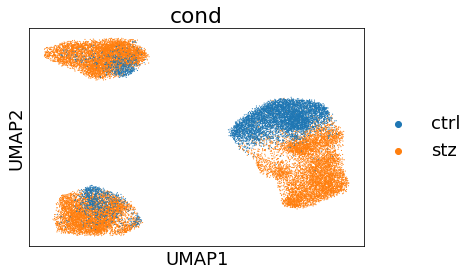

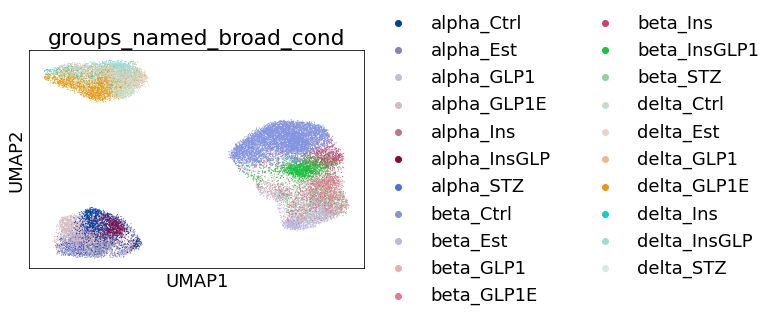

In [8]:
sc.pp.pca(adata_stz_ctrl)
sc.pp.neighbors(adata_stz_ctrl)
sc.tl.umap(adata_stz_ctrl)
sc.pl.umap(adata_stz_ctrl,color=['cond'])
sc.pl.umap(adata_stz_ctrl,color=['groups_named_broad_cond' ])


In [9]:
epoch_num=30
prob_list = models.follow_training_dyn_neural_net(adata_stz_ctrl, label_key='cond',iterNum=epoch_num, device=device)

[1,     2] loss: 0.142
[1,    12] loss: 0.683
[1,    22] loss: 0.627
[1,    32] loss: 0.568
[1,    42] loss: 0.506
[1,    52] loss: 0.454
[1,    62] loss: 0.400
[1,    72] loss: 0.373
[1,    82] loss: 0.362
[1,    92] loss: 0.332
[2,     2] loss: 0.065
[2,    12] loss: 0.283
[2,    22] loss: 0.289
[2,    32] loss: 0.277
[2,    42] loss: 0.242
[2,    52] loss: 0.247
[2,    62] loss: 0.243
[2,    72] loss: 0.231
[2,    82] loss: 0.211
[2,    92] loss: 0.213
[3,     2] loss: 0.042
[3,    12] loss: 0.196
[3,    22] loss: 0.199
[3,    32] loss: 0.202
[3,    42] loss: 0.187
[3,    52] loss: 0.182
[3,    62] loss: 0.179
[3,    72] loss: 0.175
[3,    82] loss: 0.171
[3,    92] loss: 0.163
[4,     2] loss: 0.034
[4,    12] loss: 0.165
[4,    22] loss: 0.147
[4,    32] loss: 0.158
[4,    42] loss: 0.157
[4,    52] loss: 0.153
[4,    62] loss: 0.143
[4,    72] loss: 0.141
[4,    82] loss: 0.139
[4,    92] loss: 0.137
[5,     2] loss: 0.038
[5,    12] loss: 0.131
[5,    22] loss: 0.139
[5,    32] 

In [10]:
all_conf , all_var = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata_stz_ctrl.n_obs, epoch_num=epoch_num)

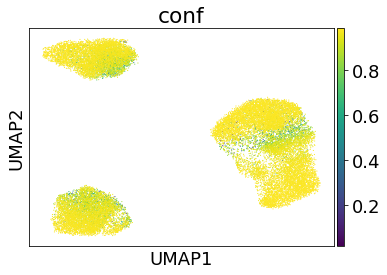

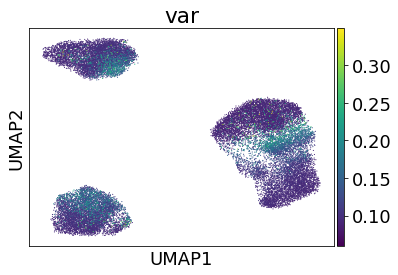

In [11]:
adata_stz_ctrl.obs['conf'] = all_conf.detach().numpy()
adata_stz_ctrl.obs['var'] = all_var.detach().numpy()
sc.pl.umap(adata_stz_ctrl , color='conf')
sc.pl.umap(adata_stz_ctrl , color='var')


In [13]:

adata_beta_stz = adata_stz_ctrl[adata_stz_ctrl.obs['groups_named_broad_cond'].isin(['beta_STZ','beta_Ins','beta_GLP1','beta_InsGLP1','beta_Est','beta_GLP1E'])]


In [14]:
sc.pp.neighbors(adata_beta_stz, n_neighbors=50)# the graph is not connected with the default value
adata_beta_stz.uns['iroot']=0
sc.tl.dpt(adata_beta_stz)

In [15]:
from scipy import stats
beta_cells_genes_dict= {
    'Beta cells activity':['Ins1', 'Ins2', 'Slc2a2', 'Trpm5', 'G6pc2',  'Slc30a8', 'Ucn3'], 
    'Beta cells dedifferentiation':['Aldh1a3', 'Serpina7']
                                    }
beta_cell_activity_genes = ['Ins1', 'Ins2', 'Slc2a2', 'Trpm5', 'G6pc2',  'Slc30a8', 'Ucn3']
beta_cell_dedifferentiation = ['Aldh1a3', 'Serpina7']
gene_tmp = np.zeros(adata_beta_stz.n_obs)
for gene in beta_cell_dedifferentiation:
    gene_tmp+=adata_beta_stz[:,gene].X.toarray()[:,0]
    
print(stats.spearmanr(gene_tmp,adata_beta_stz.obs['dpt_pseudotime']))
print(stats.spearmanr(gene_tmp,adata_beta_stz.obs['conf']))
print(1)
gene_tmp = np.zeros(adata_beta_stz.n_obs)

for gene in beta_cell_activity_genes:
    gene_tmp+=adata_beta_stz[:,gene].X.toarray()[:,0]
print("dpt")
print(stats.spearmanr(gene_tmp,adata_beta_stz.obs['dpt_pseudotime']))
print("conf")
print(stats.spearmanr(gene_tmp,adata_beta_stz.obs['conf']))


SpearmanrResult(correlation=-0.021748500342755887, pvalue=0.0739856622111069)
SpearmanrResult(correlation=0.573763408875579, pvalue=0.0)
1
dpt
SpearmanrResult(correlation=-0.2227877078417843, pvalue=1.1003424883255428e-76)
conf
SpearmanrResult(correlation=-0.662951831067924, pvalue=0.0)
